[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Пункт 2: Підбір оптимальних параметрів
Найкращі параметри для Logistic Regression: {'C': 0.1, 'penalty': 'l2'}
Найкращі параметри для Random Forest: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Пункт 3: Оцінка моделей з метриками (precision, recall, f1, support)

Logistic Regression Classification Report:
                 precision    recall  f1-score   support

       Clothing       0.34      0.27      0.30      1024
    Electronics       0.33      0.70      0.45       980
Home Appliances       0.31      0.04      0.08       996

       accuracy                           0.33      3000
      macro avg       0.33      0.34      0.28      3000
   weighted avg       0.33      0.33      0.28      3000


Random Forest Classification Report:
                 precision    recall  f1-score   support

       Clothing       0.34      0.13      0.18      1024
    Electronics       0.32      0.86      0.47       980
Home Appliances       0.16      0.00      0.01       996

    

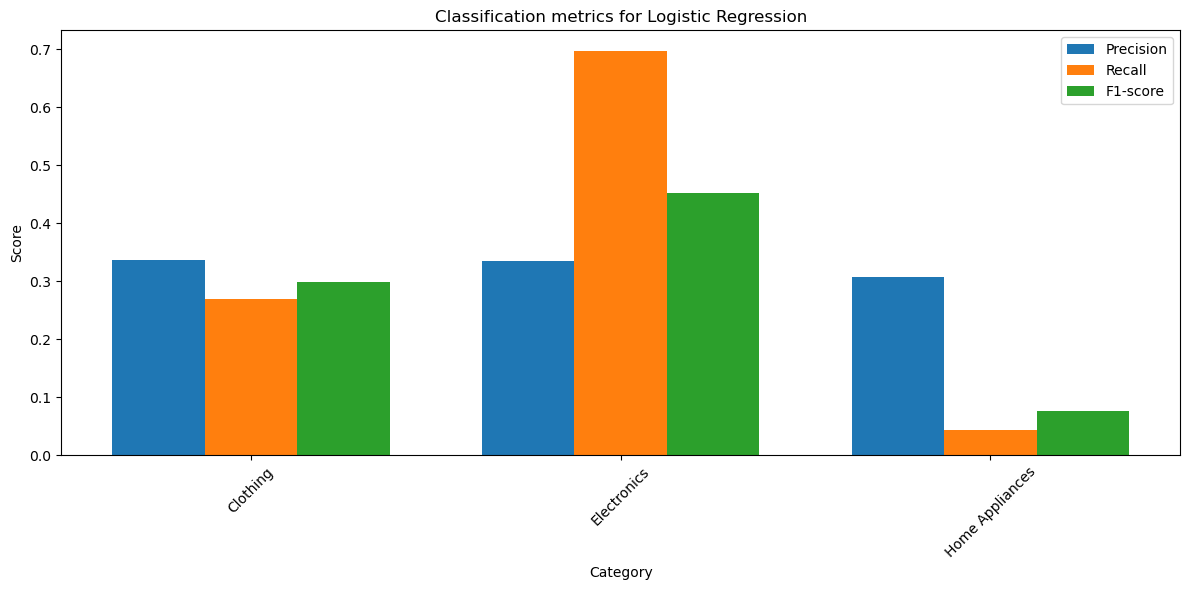

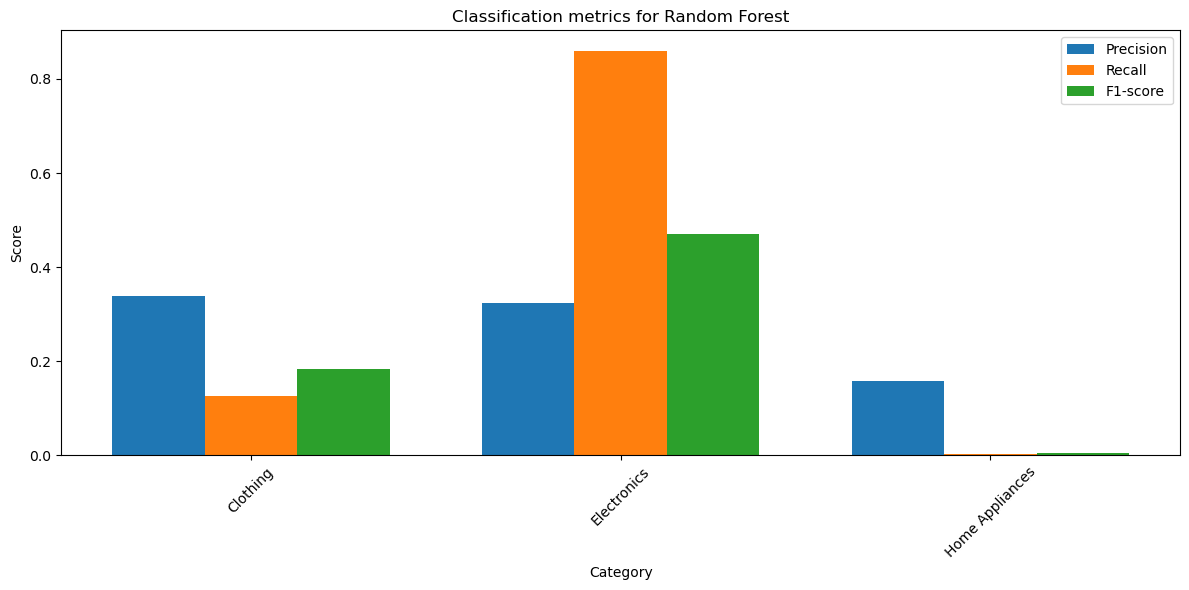

In [6]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. Завантаження даних ----
df = pd.read_csv("products.csv")
df['Product Description'] = df['Product Description'].fillna('')
df['Product Name'] = df['Product Name'].fillna('')
df['Product Tags'] = df['Product Tags'].fillna('')
texts = (df['Product Description'] + ' ' + df['Product Name'] + ' ' + df['Product Tags']).str.lower()

# ---- 2. Препроцесінг тексту ----
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

tokens = [word_tokenize(text) for text in texts]
tokens_clean = [[word for word in text if word.isalpha()] for text in tokens]
stop_words = set(stopwords.words('english'))
tokens_no_stop = [[word for word in text if word not in stop_words] for text in tokens_clean]
ps = PorterStemmer()
tokens_stemmed = [[ps.stem(word) for word in text] for text in tokens_no_stop]
lemmatizer = WordNetLemmatizer()
tokens_lemmatized = [[lemmatizer.lemmatize(word) for word in text] for text in tokens_stemmed]

# ---- 3. Формування TF-IDF матриці ----
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([" ".join(text) for text in tokens_lemmatized])
y = df['Product Category']

# ---- 4. Розділення на навчальну та тестову вибірки ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ---- 5. Побудова моделей ----
log_reg = LogisticRegression(random_state=42, max_iter=1000)
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)

# ---- 6. Підбір оптимальних параметрів ----
print("Пункт 2: Підбір оптимальних параметрів")
param_grid_lr = {'C': [0.1, 1, 10], 'penalty': ['l2']}
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=3, n_jobs=-1)
grid_lr.fit(X_train, y_train)
print("Найкращі параметри для Logistic Regression:", grid_lr.best_params_)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Найкращі параметри для Random Forest:", grid_rf.best_params_)

# ---- 7. Оцінка моделей ----
print("Пункт 3: Оцінка моделей з метриками (precision, recall, f1, support)")
y_pred_lr = grid_lr.best_estimator_.predict(X_test)
y_pred_rf = grid_rf.best_estimator_.predict(X_test)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# ---- 8. Візуалізація результатів ----
def plot_metrics(y_true, y_pred, model_name):
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, labels=np.unique(y_true))
    labels = np.unique(y_true)

    x = np.arange(len(labels))
    width = 0.25

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1, width, label='F1-score')
    plt.xticks(x, labels, rotation=45)
    plt.xlabel('Category')
    plt.ylabel('Score')
    plt.title(f'Classification metrics for {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics(y_test, y_pred_lr, "Logistic Regression")
plot_metrics(y_test, y_pred_rf, "Random Forest")